In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pysal as ps
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
import sqlite3
from shapely import wkb
%matplotlib inline

# Prep & Clean the data

We'll use a dataset I've built for this express purpose, gathering from data sources discussed in the Appendices of the competition document. 

In [2]:
eng = sqlite3.connect('brexit_and_migrants.sql')
allofit = pd.read_sql('select * from allofit', eng)
allofit['geometry'] = allofit.the_geom.apply(lambda x: wkb.loads(x, hex=True))
allofit = gpd.GeoDataFrame(allofit)
allofit.columns = [col.replace(' - ', '') for col in allofit.columns]
allofit = allofit[allofit.lad15nm != 'Isles of Scilly'] # missing significant data here

And, we'll also read in the CDRC dataset, which I've also included in the `sqlite` database and joined up with LSOAs in England. 

In [3]:
lsoas = pd.read_sql('select * from lsoa_cdrc_data', eng)
lsoas['geometry'] = lsoas.the_geom.apply(lambda x: wkb.loads(x, hex=True))
lsoas = gpd.GeoDataFrame(lsoas.drop('the_geom', axis=1))

Just to show, the lsoas:

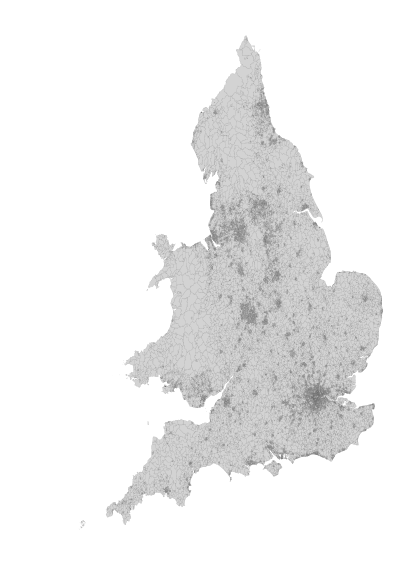

In [4]:
f = plt.figure(figsize=(6,10))
lsoas.plot(color='lightgrey', linewidth=.05, edgecolor='k', ax=plt.gca())
plt.axis('off')
plt.show()

and the local authorities:

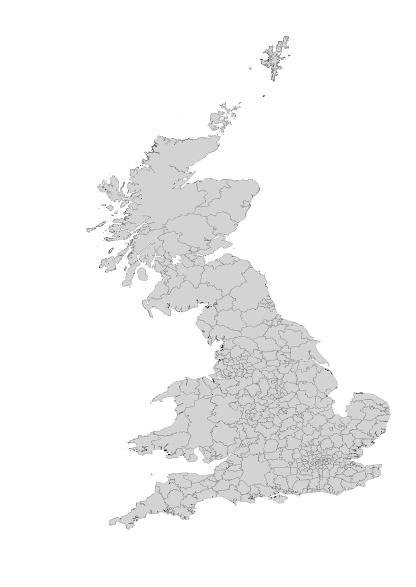

In [5]:
f = plt.figure(figsize=(6,10))
allofit.plot(color='lightgrey', linewidth=.1, edgecolor='k', ax=plt.gca())
plt.axis('off')
plt.show()

If you look carefully, you'll see I'm missing a few local authorities. But, altogether, I've got:

In [6]:
allofit.shape[0]

371

of them.

### Merging the two datasets

Now, I'm going to merge up the data I have for the LAs with the LSOAs using geopandas, merging together the two by centroid containment in a spatial join:

In [7]:
from geopandas.tools import sjoin

In [8]:
joined = sjoin(allofit, lsoas.assign(geomdupe=lsoas.geometry,
                                     centroids=lsoas.centroid)[['geometry', 'centroids', 'lsoa11cd']]\
                                     .set_geometry('centroids').rename(columns=dict(geometry='lsoa_geometry')),
               op='contains') # "trick" geopandas into taking the LSOA geometry by 
                              # making it no longer called "geometry," and instead 
                              # index geometries on the "centroids" column.

After the join (which you may not want to attempt if you don't have > 4 GB of memory in your computer, we can see that the assignment worked:

(105783.99201779434, 681788.2980403295, -20871.136885052583, 689838.7203237317)

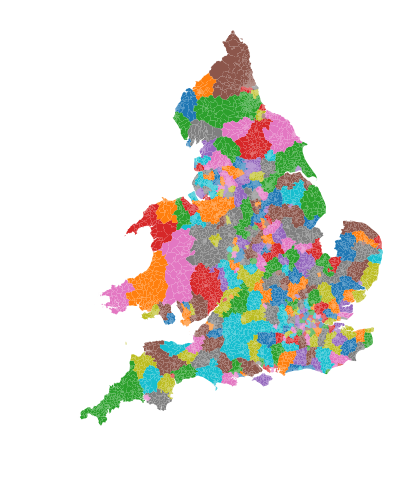

In [9]:
plt.figure(figsize=(6,8))
joined.set_geometry('lsoa_geometry').plot('Area Name', ax=plt.gca())
plt.axis('off')

# Creating the Divergences

In this step, I'll be computing the population volatility components. First, though, I'll bring in some tools from `scikit-learn` and `scipy`, as well as a progressbar indicator to keep track of longrunning computations. 

In [10]:
import sklearn.metrics as skm
from tqdm import tqdm
from scipy import stats as st

To get a list of sorted years & ethnicities, I'm going to exploit some regularities in column structure to parse out the relevant combination of ethnicity-years in the CDRC data:

In [11]:
years = sorted(list(set([col.split('y')[-1] 
                          for col in lsoas.filter(regex='_y[1234567890]')])))
ethnicities = sorted(list(set([col.split('_')[0] 
                               for col in lsoas.filter(regex='_y[1234567890]')])))

Now, for each year, i'll 
1. take that year and the next year, 
2. grab all the ethnicities in both years,
3. re-normalize the distributions so they sum to one,
4. and then compute the earth-movers distance between the two vectors. 

In [12]:
for i,year in tqdm(enumerate(years[:-1])):
    next_year = years[i+1]
    
    result = np.empty(lsoas.shape[0])
    
    thisyear_distribution = lsoas[[col + '_y{}'.format(year) for col in ethnicities]].copy()
    isnull = np.isnan(thisyear_distribution.values).all(axis=1)
    thisyear_distribution.dropna(inplace=True)
    
    thisyear_distribution_normed = (thisyear_distribution.values) / thisyear_distribution.values.sum(axis=1)[:,None]
    
    nextyear_distribution = lsoas[[col + '_y{}'.format(next_year) for col in ethnicities]]
    nextyear_distribution_normed = (nextyear_distribution.values ) / nextyear_distribution.values.sum(axis=1)[:,None]
    
    distances = list(map(lambda x: 
                         st.wasserstein_distance(*x), #earthmovers distance/Wasserman distance
    #                     st.energy_distance(*x), #another useful divergence
    #                     st.entropy(*x) # kullback-leibler divergence
                         zip(thisyear_distribution_normed, nextyear_distribution_normed)))
    
    # Here, I account for missing data distances ahead of time. 
    # This lets us compute the divergences only for the data we have. 
    result[~isnull] = distances
    result[isnull] = np.nan
    
    # if, somehow, this fails to account for all infinite divergences,
    # then something is wrong with our algorithm, since the distances
    # are not sane. Thus, I check explicitly. 
    if np.isinf(result).any():
        print("divergence!")
        break
    
    # finally, I assign the volatility for y,yt+1 (named referring to the second year)
    # back to the lsoa dataframe
    lsoas['distmove_{}'.format(next_year)] = result
    

0it [00:00, ?it/s]/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
19it [00:15,  1.20it/s]


### Population Volatility average over five years

Now, I compute the average volatility over the five years, as well as the log mean volatility:

In [13]:
lsoas = lsoas.assign(fiveyear_log_distchange = np.log(lsoas.filter(regex='^distmove_201[012345]')+.0001).mean(axis=1))
lsoas = lsoas.assign(fiveyear_distchange = lsoas.filter(regex='^distmove_201[012345]').mean(axis=1))

#### And plot the volatility in a pretty figure:

In [14]:
from legendgram import legendgram as lg
import palettable as pltt

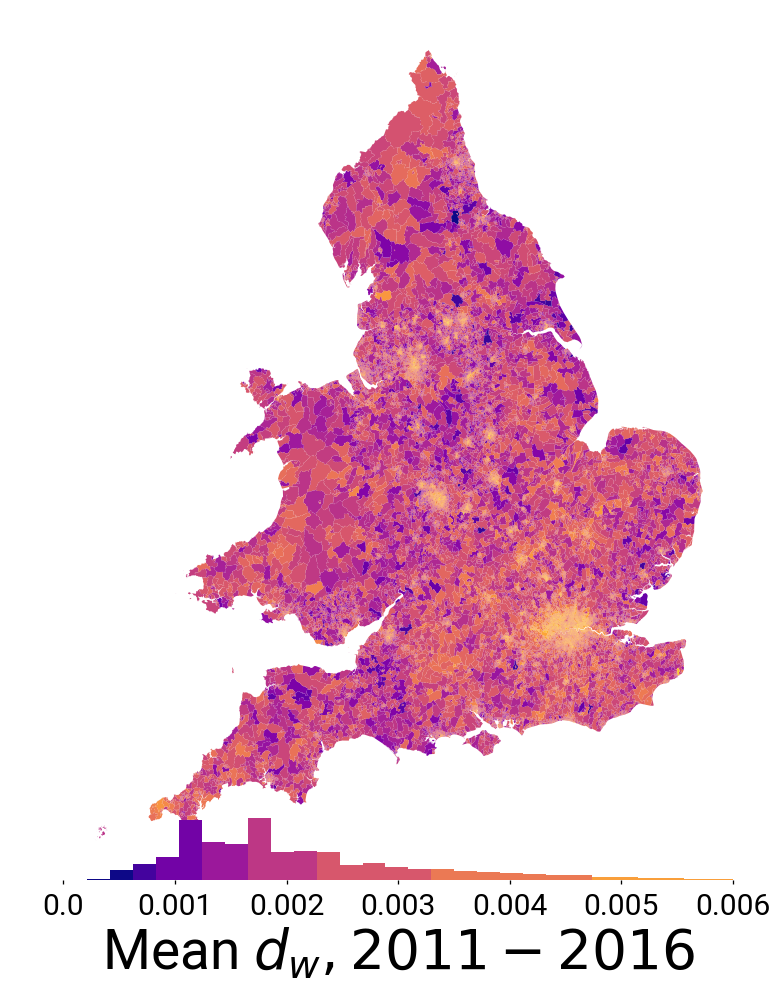

In [15]:
f,ax = plt.subplots(1,1,figsize=(12,16))

lsoas.plot('fiveyear_log_distchange', cmap='plasma', ax=ax, 
           linewidth=0, edgecolor=None, legend=False,
           )
axnew = lg(f,ax, lsoas.fiveyear_distchange, 
              np.geomspace(0.0005,.01,num=9), 
              pltt.matplotlib.Plasma_9, legend_size=(1,.075), bins=100)
axnew.set_xlim(0,.006)
#ax.set_title("Five-Year Population Volatility", fontsize=20)
ax.axis('off')
axnew.set_xticklabels(np.linspace(0,.006, num=7), fontsize=30)
axnew.set_xlabel('Mean $d_{w}, 2011-2016$', fontsize=55)
plt.show()

### Grouping these LSOAs to the Local Authority

When conducting this groupby, I'll retain both the variance and mean of the changes.

In [16]:
mean_change_ = pd.merge(joined[['lsoa11cd','lad15nm']], lsoas[['lsoa11cd', 'fiveyear_distchange']], 
                       on='lsoa11cd', how='left')
mean_change = mean_change_.groupby('lad15nm').fiveyear_distchange.mean().to_frame('mean_change')
mean_change['heterogeneity'] = mean_change_.groupby("lad15nm").fiveyear_distchange.std().values
mean_change['mean_change_z'] = mean_change.mean_change / mean_change.heterogeneity
mean_change['log_mean_change'] = np.log(mean_change.mean_change)
mean_change = pd.merge(allofit[['lad15nm', 'geometry', 'Pct_Leave']], mean_change, 
                       left_on='lad15nm', right_index=True)

Now, the standard deviation of values are stored in `heterogeneity`, the raw mean change is stored in `mean_change`, and the measure akin to the coefficient of variation is stored in `mean_change_z`. 

A line-of-best-fit scatterplot shows leave % is negatively related to `mean_change_z`

(0, 100)

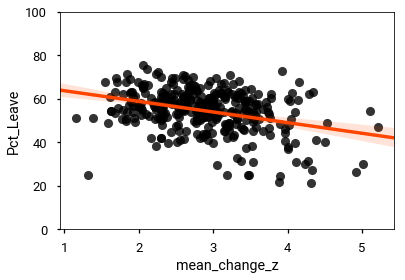

In [17]:
sns.regplot(mean_change.mean_change_z, 
            mean_change.Pct_Leave, color='k', line_kws=dict(color='orangered'))
#plt.xlim(0,.006)
plt.ylim(0,100)

And that the mean change in population volatility in a Local Authority is positive related to the standard deviation of five-year mean change in a Local Authority. 

Practically speaking, this means that local authorities with larger LSOA population volatility tend to *also* have more dispersed volatility scores. This is an understandable implication of heteroskedasticity, and is expected since the variate appears to be somewhat exponentially distributed at the LSOA scale. 

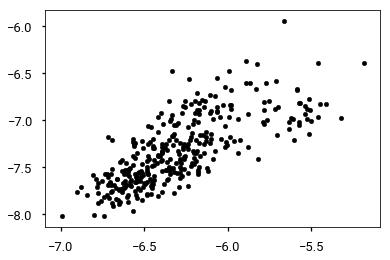

In [18]:
plt.scatter(np.log(mean_change.mean_change), 
            np.log(mean_change.heterogeneity), marker='.', color='k')
# plt.xlim(0,.006)
# plt.ylim(0,.0025)

### Finally, assign to the model data

I keep all of the model data in `allofit`, so I'll merge the two back together based on the local authority code provided by the OS. 

In [19]:
allofit = pd.merge(mean_change[['mean_change', 'mean_change_z', 'lad15nm']], allofit, on='lad15nm')

# Change in manufacturing percentage since 2016

This is straightforward. If manufacturing employment was more prevalent in 2011 for the local authority, the term is negative. If otherwise, the term is positive. 

In [20]:
allofit['Change_Pct_manufacture_2011to2016'] = allofit['Pct_manufacture(2016)'] - allofit['Pct_manufacture(2011)']

# Migrant Population Flows

This computation is somewhat more involved only because I'm not doing it using looping constructs.

First, though, let's see some of the data. 

In [21]:
pops = allofit.filter(regex='^201[654321] Resident Population') #resident population estimate by year
int_flows = allofit.filter(regex='^201[654321] Long-Term International Migration: ')
int_inflows = int_flows.filter(regex='Inflow$')
int_outflows = int_flows.filter(regex='Outflow$')

Yearly population estimates are accurate to the thousands in the APS data, but obviously I'm not dealing with potential uncertainty in these estimates in this model. 

In [22]:
pops.head()

,2011 Resident Population,2012 Resident Population,2013 Resident Population,2014 Resident Population,2015 Resident Population,2016 Resident Population
0,91000.0,91000.0,91000.0,92000.0,92000.0,92000.0
1,137000.0,138000.0,138000.0,138000.0,138000.0,139000.0
2,134000.0,134000.0,133000.0,133000.0,134000.0,133000.0
3,189000.0,190000.0,190000.0,191000.0,192000.0,193000.0
4,104000.0,104000.0,104000.0,104000.0,104000.0,104000.0


As far as the inflow/outflow is concerned, below you can see the data available for those same local authorities for the migration inflow & outflow from/to international areas:

In [23]:
int_flows.filter(like='2016').head()

,2016 Long-Term International Migration: Inflow,2016 Long-Term International Migration: Outflow
0,273.0,103.0
1,1444.0,337.0
2,318.0,93.0
3,1114.0,341.0
4,342.0,252.0


Then, I'm going to compute the percentage net inflow, which is the difference between inflow and outflow, divided by the population estimate. 

I also compute the raw net flow, which is just the difference in inflow and outflow:

In [24]:
allofit = allofit.assign(**{inflow.replace('Inflow', 'Pct_Net'): #Pct_Net is the percentage of population net migration
                            (allofit[inflow].values - allofit[outflow].values) #difference
                               /allofit[pop].values #divide by population
                for inflow,outflow,pop in zip(int_inflows.columns, 
                                              int_outflows.columns, 
                                              pops.columns)})
allofit = allofit.assign(**{inflow.replace('Inflow', 'Net'): #Net is the raw difference in flows
                            (allofit[inflow].values - allofit[outflow].values) #difference
                            for inflow,outflow in zip(int_inflows.columns, 
                                                      int_outflows.columns)})

Then, I do this all again for the domestic sources:

In [25]:
dom_flows = allofit.filter(regex='^201[654321] Internal Migration\n \(within UK\): ')
dom_inflows = allofit.filter(regex='^201[654321] Internal Migration\n \(within UK\): ').filter(regex='Inflow$')
dom_outflows = allofit.filter(regex='^201[654321] Internal Migration\n \(within UK\): ').filter(regex='Outflow$')

allofit = allofit.assign(**{inflow.replace('Inflow', 'Pct_Net'): 
                            (allofit[inflow].values - allofit[outflow].values) #difference
                             / allofit[pop].values #divide by population
                for inflow,outflow,pop in zip(dom_inflows.columns, 
                                              dom_outflows.columns, 
                                              pops.columns)})

allofit = allofit.assign(**{inflow.replace('Inflow', 'Net'): 
                            (allofit[inflow].values - allofit[outflow].values) #difference
                for inflow,outflow in zip(dom_inflows.columns, 
                                          dom_outflows.columns)})

Finally, I compute the sum of the net migration from 2011 to 2016, as well as the mean yearly net percentage migration from 2011 to 2016. 

In [26]:
allofit['fiveyear_net_external_migration'] = allofit.filter(regex='^201[654321] Long-Term International Migration:')\
                                                    .filter(regex=' Net$').sum(axis=1)
allofit['fiveyear_mean_net_external_migration'] = allofit.filter(regex='^201[654321] Long-Term International Migration:')\
                                                    .filter(regex='Pct_Net$').mean(axis=1) * 100

allofit['fiveyear_net_internal_migration'] = allofit.filter(regex='^201[654321] Internal Migration\n \(within UK\):')\
                                                    .filter(regex=' Net$').sum(axis=1)
allofit['fiveyear_mean_net_internal_migration'] = allofit.filter(regex='^201[654321] Internal Migration\n \(within UK\):')\
                                                    .filter(regex='Pct_Net$').mean(axis=1) * 100

And, at the end of all of this data wrangling, I ensure that the dataframe is still a spatial dataframe:

In [27]:
allofit = gpd.GeoDataFrame(allofit)

and make a few more plots:

/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


Text(0.5,0.8,'Average Net Immigration Flow \n$net_t = \\frac{Inflow_t - Outflow_t}{Population_t}$')

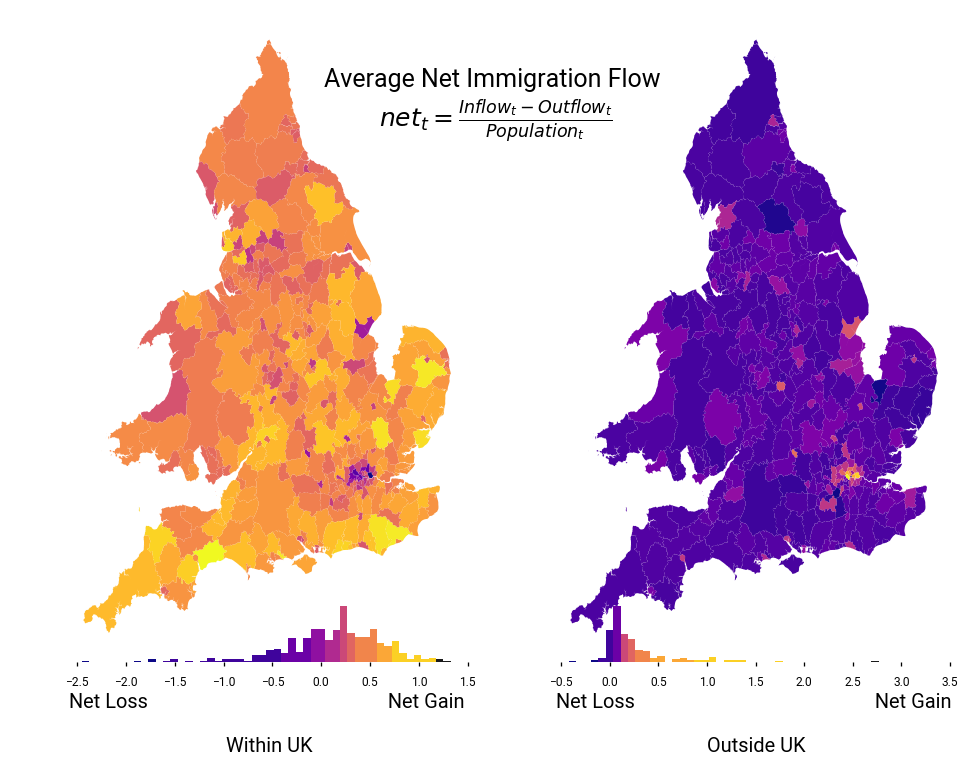

In [28]:
f,ax = plt.subplots(1,2,figsize=(16,12))
allofit.plot("fiveyear_mean_net_internal_migration", cmap='plasma',ax=ax[0])
allofit.plot("fiveyear_mean_net_external_migration", cmap='plasma',ax=ax[1])
ax[0].axis('off')
ax[1].axis('off')
legs = []
legs.append(lg(f,ax[0], allofit.fiveyear_mean_net_internal_migration.fillna(0), 
              np.percentile(allofit.fiveyear_mean_net_internal_migration.fillna(0), 
                            q=np.linspace(1,99,10)),
              pltt.matplotlib.Plasma_10,
              legend_size=(1,.09)))
legs.append(lg(f,ax[1], allofit.fiveyear_mean_net_external_migration.fillna(0), 
              np.percentile(allofit.fiveyear_mean_net_external_migration.fillna(0), 
                            q=np.linspace(1,99,10)),
              pltt.matplotlib.Plasma_10,
              legend_size=(1,.09))) 
legs[0].set_xlabel("Net Loss                                                Net Gain\n\n Within UK", fontsize=20)
legs[1].set_xlabel("Net Loss                                                Net Gain\n\n Outside UK", fontsize=20)
plt.suptitle("Average Net Immigration Flow \n$net_t = \\frac{Inflow_t - Outflow_t}{Population_t}$", 
             fontsize=25, y=.8)

Note that the internal and external migration are somewhat negatively related:

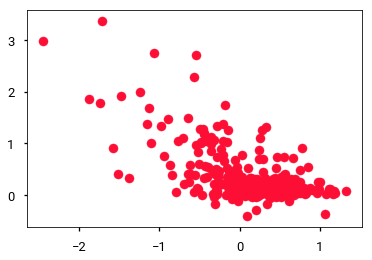

In [29]:
plt.scatter(allofit.fiveyear_mean_net_internal_migration, 
            allofit.fiveyear_mean_net_external_migration)

# Change in foreign borns

For this, we can just directly compute the year-on-year difference between the columns in the last 5 years for ethnic non-UK and white non-UK migrants:

In [30]:
last5year_ethnicnonUK = ['Pct_ethnic_nonUKborn({})'.format(y) for y in range(2011,2017)]
last5year_whitenonUK = ['Pct_white_nonUKborn({})'.format(y) for y in range(2011,2017)]

In [31]:
allofit['fiveyear_change_ethnicnonUK'] = allofit[last5year_ethnicnonUK].diff(axis=1).mean(axis=1)
allofit['fiveyear_change_whitenonUK'] = allofit[last5year_whitenonUK].diff(axis=1).mean(axis=1)

And, the relationship between the two is shown below:

Text(0.5,1,'Five-year change in non-UK populations')

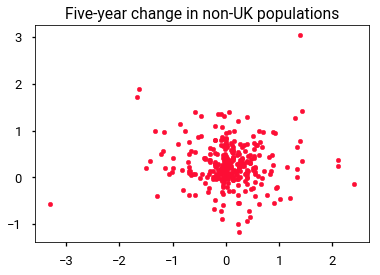

In [32]:
plt.scatter(allofit.fiveyear_change_ethnicnonUK,
            allofit.fiveyear_change_whitenonUK, marker='.')
plt.title("Five-year change in non-UK populations")

# Modelling

To do this, I'll grab all the relevant traits in my data for the year `try_year`. 

I'm doing this to avoid bringing forward all the columns in `allofit`, of which there are many.

In [41]:
try_year = '2016'
model_cols = ['Pct_Leave', 'Pct_noqual_16to64({try_year})'.format(try_year=try_year), 
              'Pct_degree_16to64({try_year})'.format(try_year=try_year), 
              'Change_Pct_manufacture_2011to2016', 
              'Pct_unemployed_white_16up({try_year})'.format(try_year=try_year),
              'Pct_ethnic_nonUKborn({try_year})'.format(try_year=try_year), 
              'fiveyear_change_ethnicnonUK',
              'Pct_white_nonUKborn({try_year})'.format(try_year=try_year),
              'fiveyear_change_whitenonUK',
              'Pct_16to19 ({})'.format(try_year),
              'Pct_20to24 ({})'.format(try_year),
              'Pct_50+ ({})'.format(try_year),
              'mean_change', 'mean_change_z',
              'fiveyear_mean_net_external_migration',
              'fiveyear_mean_net_internal_migration', 
              'Votes_Cast', 'Region', 'Area Name']
model_data = allofit[model_cols]

To prevent issues in the statsmodels formula interface, we need to replace any column with `+` in it to use `up`. 

In [42]:
model_data.columns=[c.replace('({try_year})'.format(try_year=try_year), '')\
                     .strip().replace('+','up') 
                    for c in model_data.columns]

Further, I'm going to try adding a London fixed effect to this model, just for exploratory purposes. 

In [43]:
model_data['isLondon'] = model_data.Region == 'London'

/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
import statsmodels.formula.api as smf

Now, I fit the same model described in the presentation using simple OLS (single-slope) plus a London fixed effect. 

In [45]:
canonmod = smf.ols('Pct_Leave ~ Pct_noqual_16to64 + Pct_degree_16to64 + Change_Pct_manufacture_2011to2016 '
        '+ Pct_white_nonUKborn + fiveyear_change_ethnicnonUK'
        '+ Pct_ethnic_nonUKborn + fiveyear_change_whitenonUK'
        '+ Pct_unemployed_white_16up'
        '+ fiveyear_mean_net_internal_migration'
        '+ fiveyear_mean_net_external_migration'
        '+ mean_change_z'
        '+ Pct_16to19 + Pct_20to24 + Pct_50up'
        '+ isLondon + I(Votes_Cast/1000)', data=model_data.fillna(0)).fit()
canonmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Pct_Leave   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     76.40
Date:                Wed, 18 Apr 2018   Prob (F-statistic):          6.98e-100
Time:                        01:21:20   Log-Likelihood:                -1002.5
No. Observations:                 343   AIC:                             2039.
Df Residuals:                     326   BIC:                             2104.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               86.5556      4.011     21.580      0.000      78.665      94.446
isLondon[T.True]                        -0.2604      1.469     -0.177      0.859      -3.150       2.630
Pct_noqual_16to64                       -0.0296      0.097     -0.306      0.760      -0.220       0.161
Pct_degree_16to64                       -0.7562      0.039    -19.615      0.000      -0.832      -0.680
Change_Pct_manufacture_2011to2016       -0.0734      0.077     -0.953      0.341      -0.225       0.078
Pct_white_nonUKborn                      0.0492      0.083      0.594      0.553      -0.114       0.212
fiveyear_change_ethnicnonUK              1.1965      0.477      2.506      0.013       0.257       2.136
Pct_ethnic_nonUKborn                     0.1030      0.072      1.429      0.154      -0.039       0.245
fiveyear_change_whitenonUK               1.7167      0.562      3.052      0.002       0.610       2.823
Pct_unemployed_white_16up                0.1934      0.133      1.450      0.148      -0.069       0.456
fiveyear_mean_net_internal_migration     1.5839      0.748      2.119      0.035       0.113       3.055
fiveyear_mean_net_external_migration    -1.6191      0.807     -2.005      0.046      -3.208      -0.031
mean_change_z                           -1.0570      0.432     -2.447      0.015      -1.907      -0.207
Pct_16to19                              -0.4673      0.175     -2.666      0.008      -0.812      -0.122
Pct_20to24                              -0.4523      0.130     -3.467      0.001      -0.709      -0.196
Pct_50up                                -0.0363      0.053     -0.684      0.494      -0.141       0.068
I(Votes_Cast / 1000)                    -0.0151      0.006     -2.750      0.006      -0.026      -0.004
==============================================================================
Omnibus:                        1.739   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.419   Jarque-Bera (JB):                1.652
Skew:                          -0.170   Prob(JB):                        0.438
Kurtosis:                       3.003   Cond. No.                     1.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Most of the results for the more complicated models are similar to this model. 

## Fitting a varying-intercept model in stan:

In [47]:
import pystan as pst

If you don't know how to do this, check out the wonderful pages for [stan example models](https://github.com/stan-dev/example-models). I tend to prefer working in stan nowadays, since I can use the same model in R as in python (if I can figure out how to express it :] )

In [48]:
regional_intercept_model = """
data {
    int N; // number of observations
    int P; // number of covariates, fitting intercept separately
    int J; // number of regions
    matrix[N,P] X; // design
    vector[N] Y; // response
    int region_lut[N]; // region lookup table, containing the region j for each observation i
}
parameters{
    real<lower=0> response_dispersion; // standard deviation of y
    real<lower = 0> intercept_dispersion; // standard deviation of the intercepts
    real global_mean; // hypermean
    vector[P] slopes; // slope estimates
    vector[J] region_means; // means for each region, will be "centered" around hypermean
}

transformed parameters{
    // I find it simpler to define the predictor in this block rather than in the model block.
    vector[N] y_hat; 
    for (i in 1:N){
        y_hat[i] = region_means[region_lut[i]] + X[i,]*slopes;
    }
}

model {
    response_dispersion ~ cauchy(0,5); // prior on response deviation is cauchy(0,5), bounded above zero
    intercept_dispersion ~ cauchy(0,5); // prior on intercept deviation is the same, see Polson & Scott (2012)
    slopes ~ normal(0,1000); // vague normal prior on beta. comment out to make this flat improper
    region_means ~ normal(global_mean,intercept_dispersion);
    Y ~ normal(y_hat, response_dispersion);
    }
"""

This model then is compiled:

In [49]:
sm2 = pst.StanModel(model_code=regional_intercept_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76654987c193984b42c3005fb9065fb2 NOW.


And, to demonstrate, I'll filter out the irrelevant names for the model:

In [51]:
stanmod_names =[col for col in model_data.columns 
                              if not (col.startswith('is') or col in ('Pct_Leave', 'Area Name', 
                                                                      'Region', 'mean_change')
                                      or col.endswith('rescale'))]
print('The Stan model is using:')
stanmod_names

The Stan model is using:


['Pct_noqual_16to64',
 'Pct_degree_16to64',
 'Change_Pct_manufacture_2011to2016',
 'Pct_unemployed_white_16up',
 'Pct_ethnic_nonUKborn',
 'fiveyear_change_ethnicnonUK',
 'Pct_white_nonUKborn',
 'fiveyear_change_whitenonUK',
 'Pct_16to19',
 'Pct_20to24',
 'Pct_50up',
 'mean_change_z',
 'fiveyear_mean_net_external_migration',
 'fiveyear_mean_net_internal_migration',
 'Votes_Cast']

Now, I'm grabbing the model from within the `model_data` dataframe, converting `Votes_Cast` to be thousands of votes cast, and constructing a `membership` list, which records which region each observation is in:

In [52]:
X = model_data.fillna(0)[stanmod_names].values
X[:,-1] = X[:,-1]/1000 #ensure votes_cast is rescaled to thousand-votes cast
regions = model_data.Region.unique().tolist()
#increment since python is zero index but stan is one index
membership = model_data.Region.apply(lambda x: regions.index(x) + 1) 
membership = list(membership)
N,P = X.shape

# this is the data the stan model will use.
# note that the X matrix is mean-centered. 
datadict = dict(
                N=N,
                P=P,
                J=len(regions),
                X=(X-X.mean(axis=0)),
                Y=model_data['Pct_Leave'].fillna(0).values,
                region_lut = membership,
)

## Then, we fit the model:

In [53]:
varying_intercepts = sm2.sampling(data=datadict)

/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


#### And I like my own summaries which focus on the posterior percentiles and the change in respone caused by moving across the IQR for the variate:

In [54]:
iqr_magnitude = np.subtract(*np.percentile(X-X.mean(axis=0), q=(75,25),axis=0))

In [55]:
summary_table = np.percentile(varying_intercepts.extract()['slopes'], q=(50,2.5,97.5), axis=0).T
med,low,hi= summary_table.T
signif = (np.sign(low) == np.sign(hi))
pd.DataFrame(summary_table,
             columns=['Median', '2.5%', '97.5%'], 
             index=stanmod_names).assign(**{"$\Delta$ IQR":iqr_magnitude * med}).round(4)

,Median,2.5%,97.5%,$\Delta$ IQR
Pct_noqual_16to64,-0.0622,-0.2570,0.1340,-0.2487
Pct_degree_16to64,-0.7626,-0.8377,-0.6840,-10.7149
Change_Pct_manufacture_2011to2016,-0.0742,-0.2207,0.0699,-0.2598
Pct_unemployed_white_16up,0.2075,-0.0429,0.4567,0.6017
Pct_ethnic_nonUKborn,0.0802,-0.0568,0.2115,0.4571
fiveyear_change_ethnicnonUK,1.2578,0.3406,2.1458,0.4570
Pct_white_nonUKborn,0.0629,-0.0980,0.2157,0.3115
fiveyear_change_whitenonUK,1.5907,0.5567,2.6661,0.7954
Pct_16to19,-0.4397,-0.7448,-0.1212,-0.8023
Pct_20to24,-0.3930,-0.6354,-0.1418,-1.1576


# Model Fit

The overall fit is rather good:

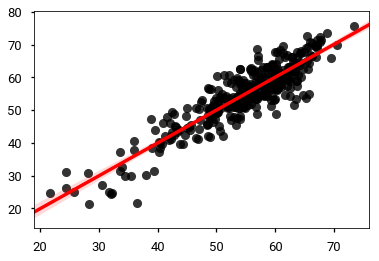

In [58]:
sns.regplot(np.median(varying_intercepts.extract()['y_hat'],axis=0), 
            datadict['Y'], color='r', scatter_kws=dict(color='k'))

With an R squared of:

In [59]:
SSR = ((datadict['Y'] - datadict['Y'].mean())**2).sum()
u = (np.median(varying_intercepts.extract()['y_hat'],axis=0) - datadict['Y'])
SSE = (u**2).sum()
R2 = 1 - SSE/SSR

In [60]:
R2

0.8116880441467712

an MSE of:

In [61]:
SSE/len(u)

18.10030480671452

# Model Adequacy

One way I like to check model adequacy is to check how likely an observation is "misclassified" as Leave when it should be classified as Remain. This is because it's possible that errors accumulate near the margin in one direction, and are balanced by errors at the extremes. While this might show up in a residual-versus-fit plot, it's not always obvious. 

Text(0,0.5,'Residual')

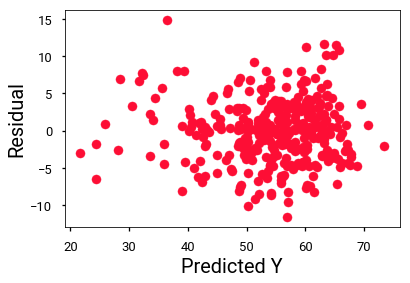

In [77]:
plt.scatter(np.median(varying_intercepts.extract()['y_hat'],axis=0),
         u)
plt.xlabel("Predicted Y", fontsize=20)
plt.ylabel("Residual", fontsize=20)

Although in this case there appears to be no strong relationship between residuals and fit, we can still look for systematic misclassifications using a confusion matrix. 

Thus, the confusion matrix for this model is:

In [78]:
pred_leave = (np.median(varying_intercepts.extract()['y_hat'],axis=0) > 50)
obs_leave = datadict['Y'] > 50
confusion = np.round(skm.confusion_matrix(pred_leave, obs_leave) / len(u),3)
confusion

array([[0.198, 0.047],
       [0.044, 0.711]])

Which means that around 90% of predictions classify the local authority correctly, in terms of Win/Lose for Brexit, and the errors in prediction are nearly symmetrical (i.e. we're not overestimating/underestimating Leave sentiment systematically through the model, which is *not* guaranteed by unbiased estimation).

Revisiting our previous plot, but coloring by the classification:

Text(0,0.5,'Residual')

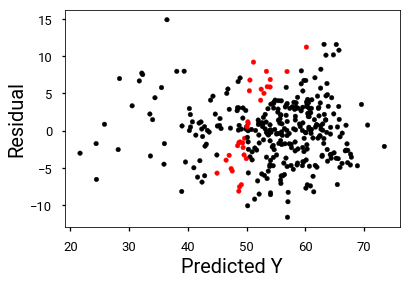

In [83]:
plt.scatter(np.median(varying_intercepts.extract()['y_hat'],axis=0),
            u, c=np.array(['r','k'])[(pred_leave == obs_leave).astype(int)],
            marker='.')
plt.xlabel("Predicted Y", fontsize=20)
plt.ylabel("Residual", fontsize=20)